# read in data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('train.tsv', sep='\t')
df_train, df_test = train_test_split(df)

In [2]:
df_train.shape, df_test.shape

((1111901, 8), (370634, 8))

In [3]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1169704,1169704,Jessica Simpson IPad Mini Cover,3,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,14.0,0,Great iPad mini case/cover. Has room for your ...
383372,383372,Aum Alex and Ani bracelet,3,Women/Jewelry/Bracelets,ALEX AND ANI,14.0,0,Aum symbol Alex and Ani bracelet
946265,946265,Chantel bundle special,3,Women/Dresses/Full-Length,NaN,120.0,1,These two dresses are listed individually in m...
1103938,1103938,Sticker - Mickey Hat - iPhone - Black,1,Electronics/Cell Phones & Accessories/Cell Pho...,NaN,3.0,1,Sticker - Disney Mickey Hat - iPhone - Black
960040,960040,Free ship xs pink vs panties,1,Women/Underwear/Panties,PINK,13.0,1,Brand new Nwt Green panty is thong Other two a...


In [4]:
df_train.describe(include='all')

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.111901e+06,1111901,1.111901e+06,1107138,637030,1.111901e+06,1.111901e+06,1111898
unique,NaN,936631,NaN,1263,4456,NaN,NaN,967670
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,NaN,NaN,No description yet
freq,NaN,1663,NaN,44950,40514,NaN,NaN,61777
mean,7.410784e+05,NaN,1.907864e+00,NaN,NaN,2.677402e+01,4.467430e-01,NaN
std,4.278977e+05,NaN,9.032937e-01,NaN,NaN,3.880237e+01,4.971558e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.705090e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.411490e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111453e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


In [5]:
import keras

def preprocess(df):
    category_ids = {v: i for i, v in enumerate(df.category_name.unique(), start=1)}
    brand_ids = {v: i for i, v in enumerate(df.brand_name.unique(), start=1)}
    df['category_id'] = df.category_name.map(category_ids)
    df['brand_id'] = df.brand_name.map(brand_ids)
    
    df[['category_id', 'brand_id', 'item_condition_id']].fillna(0, inplace=True)
    df['text'] = df.name + ' ' + df.item_description.str.replace('No description yet', '')
    df['text'] = df.text.astype(str)
    
    return df

df_train = preprocess(df_train)
df_test = preprocess(df_test)

Using TensorFlow backend.
/home/dante/venvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/dante/venvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/dante/venvs/python36/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [6]:
df_train.text.str.count(' ').describe()

count    1.111901e+06
mean     2.899281e+01
std      3.090929e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.900000e+01
75%      3.500000e+01
max      2.510000e+02
Name: text, dtype: float64

In [7]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_id,brand_id,text
1169704,1169704,Jessica Simpson IPad Mini Cover,3,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,14.0,0,Great iPad mini case/cover. Has room for your ...,1,1,Jessica Simpson IPad Mini Cover Great iPad min...
383372,383372,Aum Alex and Ani bracelet,3,Women/Jewelry/Bracelets,ALEX AND ANI,14.0,0,Aum symbol Alex and Ani bracelet,2,2,Aum Alex and Ani bracelet Aum symbol Alex and ...
946265,946265,Chantel bundle special,3,Women/Dresses/Full-Length,NaN,120.0,1,These two dresses are listed individually in m...,3,1,Chantel bundle special These two dresses are l...
1103938,1103938,Sticker - Mickey Hat - iPhone - Black,1,Electronics/Cell Phones & Accessories/Cell Pho...,NaN,3.0,1,Sticker - Disney Mickey Hat - iPhone - Black,4,1,Sticker - Mickey Hat - iPhone - Black Sticker ...
960040,960040,Free ship xs pink vs panties,1,Women/Underwear/Panties,PINK,13.0,1,Brand new Nwt Green panty is thong Other two a...,5,3,Free ship xs pink vs panties Brand new Nwt Gre...


# build byte pair encoder

In [8]:
%load_ext Cython

In [9]:
class Node:
    def __init__(self, parent=None):
        self.parent = parent
        self.children = {}
        self.index = None

    def __repr__(self):
        return f'Node(index={self.index}, children={self.children})'
    
    def get(self, key, default=None):
        return self.children.get(key, default)
    
    def __getitem__(self, key):
        return self.children[key]
    
    def __setitem__(self, key, value):
        self.children[key] = value
        
    def __contains__(self, key):
        return key in self.children


def build_bpe_tree(vocab):
    root = Node()
    for word, index in vocab.items():
        current_node = root
        for n, c in enumerate(word, start=1):
            if not c in current_node:
                current_node[c] = Node()
            current_node = current_node[c]
            if n == len(word):
                current_node.index = index
    return root


def apply_bpe_tree(text, tree):
    output = []
    pos = 0
    last_node = tree
    while pos <= len(text) - 1:
        node = last_node.get(text[pos])
        # we can't search the tree any further
        if node is None:
            # we couldn't search the tree any further but we
            # ended up at a node that doesn't correspond to a
            # word in the learned vocabulary.
            # In this case we'll traverse back through the tree
            # until we hit a node with an index.
            if last_node.index is None:
                while last_node.index is not None:
                    last_node = last_node.parent
                    pos -= 1
            # add the last seen index to the output
            # and reset variables for next run through
            output.append(last_node.index)
            if last_node is not tree:
                last_node = tree
                continue
            node = tree
        last_node = node
        pos += 1
    output.append(last_node.index)
    return output


In [10]:
%%cython
def get_stats(list vocab):
    cdef c1, c2
    cdef list word
    cdef int freq, vocab_pos, word_pos
    cdef dict pair_stats = {}
    cdef dict pair_indices = {}
    cdef tuple pair
    for vocab_pos in range(len(vocab)):
        word, freq = vocab[vocab_pos]
        for word_pos in range(len(word) - 1):
            pair = word[word_pos], word[word_pos + 1]
            if not pair in pair_stats:
                pair_stats[pair] = 0
            pair_stats[pair] += freq
            if not pair in pair_indices:
                pair_indices[pair] = []
            pair_indices[pair].append((vocab_pos, word_pos))
    return pair_stats, pair_indices


def merge_vocab(tuple pair, list vocab, list pair_indices):
    cdef int vocab_pos, word_pos
    cdef list word
    for vocab_pos, word_pos in reversed(pair_indices):
        word, _ = vocab[vocab_pos]
        word[word_pos] = word[word_pos] + word[word_pos + 1]
        word.pop(word_pos + 1)
    return vocab


In [11]:
import collections
import time

import sklearn
import numpy as np


class BytePairEncoder(sklearn.base.TransformerMixin):    
    _unkown_character = '<unk>'
    _space_escape = '▁'

    def __init__(self, target_vocab_size, vocab_threshold=None, log_level=None):
        self.target_vocab_size = target_vocab_size
        self.log_level = log_level
        self.vocab_threshold = vocab_threshold

        # these will all be set during .fit()
        self.vocab = None
        self._vocab_stats = None
        self._reverse_vocab = None
        self._bpe_tree = None

    def fit(self, X):
        # get the initial vocabular consisting of all unique characters
        initial_vocab = set(X)
        initial_vocab.add(self._space_escape)

        words = self._split_X(X)
        vocab = [(list(word), freq) for word, freq in collections.Counter(words).items()]

        t_started = time.time()
        i = 0
        while self._vocab_size(vocab) < self.target_vocab_size:
            if self.log_level is not None \
                    and i and (i + 1) % self.log_level == 0:
                print(f'{i+1} iterations complete in {time.time() - t_started}')
            pair_stats, pair_index = get_stats(vocab)
            best = max(pair_stats, key=pair_stats.get)
            if self.vocab_threshold is not None \
                    and pair_stats[best] < self.vocab_threshold:
                print(f'Stopping after {i} iterations. Best pair occurs '
                      f'{pair_stats[best]} < {self.vocab_threshold} times')
                break
            vocab = merge_vocab(best, vocab, pair_index[best])
            i += 1

        # build the final vocabulary
        vocab_stats = collections.Counter()
        _ = [vocab_stats.update({subword: freq})
                                for word, freq in vocab
                                for subword in word]
        final_vocab = set(vocab_stats)
        final_vocab.update(initial_vocab)
        final_vocab = {k: i for i, k in enumerate(final_vocab, start=1)}
        final_vocab[self._unkown_character] = 0
        self.vocab = final_vocab

        # these are needed for .transform() and .inverse_transform()
        self._reverse_vocab = {i: k for k, i in self.vocab.items()}
        self._bpe_tree = build_bpe_tree(self.vocab)

        # keep this for curiosity/debugging
        self._vocab_stats = vocab_stats

    def transform(self, X):
        X = self._split_X(X)
        return np.concatenate([self._transform_string(x) for x in X])

    def _transform_string(self, X):
        tokens = apply_bpe_tree(X, self._bpe_tree)
        return np.array([0 if t is None else t for t in tokens])                

    def inverse_transform(self, X):
        return [self._reverse_vocab[t] for t in X]

    def _split_X(self, X):
        return [word + self._space_escape for word in X.split()]

    def _vocab_size(self, vocab):
        return len(set(subword for word, _ in vocab for subword in word))


In [12]:
bpe_text = ' '.join(df_train.item_description.sample(30000))
bpe_text[:150]

'Size small Bought from converse store New with tags Color is black retail 19.99$ Size 6 toddler kids unisex red,black,white Uniqlo black zip up. Size '

In [ ]:
len(bpe_text)

In [13]:
bpe = BytePairEncoder(30000, log_level=1000, vocab_threshold=5)
%time bpe.fit(bpe_text)

1000 iterations complete in 319.35621762275696
2000 iterations complete in 649.30331158638
3000 iterations complete in 986.5436532497406
4000 iterations complete in 1325.2175116539001
5000 iterations complete in 1665.115700006485
6000 iterations complete in 2003.7753021717072
7000 iterations complete in 2338.2903730869293
8000 iterations complete in 2670.8005607128143
9000 iterations complete in 3000.8742854595184
10000 iterations complete in 3329.566202402115
11000 iterations complete in 3653.9510748386383
12000 iterations complete in 3974.5807600021362
13000 iterations complete in 4291.8101375103
14000 iterations complete in 4604.424010753632
15000 iterations complete in 4913.072614192963
16000 iterations complete in 5218.674493312836
17000 iterations complete in 5519.2871832847595
18000 iterations complete in 5816.421611070633
19000 iterations complete in 6109.66294169426
20000 iterations complete in 6399.095827817917
21000 iterations complete in 6684.125005722046
22000 iterations c

In [14]:
len(bpe.vocab)

24557

In [15]:
bpe.vocab

{'System': 1,
 'Frances': 2,
 'cast': 3,
 'FedEx▁': 4,
 'creamy▁': 5,
 'Tiffany▁': 6,
 'sive▁': 7,
 'wings▁': 8,
 'eu': 9,
 'ona▁': 10,
 'shire▁': 11,
 'DOU': 12,
 'Bees▁': 13,
 'Rat': 14,
 'EXCLUS': 15,
 'mer)▁': 16,
 'Sequin▁': 17,
 'spaghetti▁': 18,
 'MSRP:▁': 19,
 'kin▁': 20,
 'empty▁': 21,
 'zed▁': 22,
 'scape▁': 23,
 'steel.▁': 24,
 'shu': 25,
 'y;▁': 26,
 'FORM▁': 27,
 'HUGE▁': 28,
 'Blur▁': 29,
 'RARE': 30,
 'pl': 31,
 'count': 32,
 '●●▁': 33,
 'fabric': 34,
 'Froz': 35,
 "Disney's▁": 36,
 'towards▁': 37,
 '21,▁': 38,
 'langu': 39,
 'Tw': 40,
 'only!▁': 41,
 'sh!▁': 42,
 'Playstation▁': 43,
 'Gabbana▁': 44,
 'AM': 45,
 'Oh▁': 46,
 'Ornam': 47,
 '6.5': 48,
 'free/': 49,
 'image▁': 50,
 'mugs,▁': 51,
 '36"▁': 52,
 'War▁': 53,
 'shir': 54,
 'Best▁': 55,
 'B,▁': 56,
 'individual▁': 57,
 'Mercari': 58,
 'AV': 59,
 'Jack▁': 60,
 'Collagen▁': 61,
 'Knee▁': 62,
 'etc..▁': 63,
 'ussy▁': 64,
 'hands▁': 65,
 'GY': 66,
 'Helps▁': 67,
 'stuck▁': 68,
 'chak': 69,
 '************': 70,
 'sad▁'

In [16]:
bpe._vocab_stats['92%▁']

26

In [17]:
import joblib
joblib.dump(bpe, 'byte-pair-encoder-raw-case.pkl')

['byte-pair-encoder-raw-case.pkl']

# encode/decode some strings

## performance

In [18]:
len(bpe_text)

4452222

In [19]:
%time tokens = bpe.transform(bpe_text)

CPU times: user 3.97 s, sys: 32 ms, total: 4.01 s
Wall time: 4.01 s


In [20]:
%time bpe.inverse_transform(tokens)

CPU times: user 227 ms, sys: 4 ms, total: 231 ms
Wall time: 231 ms


['Size▁',
 'small▁',
 'Bought▁',
 'from▁',
 'converse▁',
 'store▁',
 'New▁',
 'with▁',
 'tags▁',
 'Color▁',
 'is▁',
 'black▁',
 'retail▁',
 '19.',
 '99',
 '$▁',
 'Size▁',
 '6▁',
 'toddler▁',
 'kids▁',
 'unisex▁',
 '<unk>',
 '<unk>',
 'white▁',
 '<unk>',
 'lo▁',
 'black▁',
 'zip▁',
 'up.▁',
 'Size▁',
 'small.▁',
 'Basic▁',
 'black▁',
 'zip▁',
 'up▁',
 'will▁',
 'match▁',
 'everything.▁',
 'Hooded▁',
 'and▁',
 'slim▁',
 'fit.▁',
 '<unk>',
 '#▁',
 'Abercrombie▁',
 'and▁',
 '<unk>',
 '/▁',
 '<unk>',
 '/▁',
 '<unk>',
 '/▁',
 'American▁',
 '<unk>',
 '/▁',
 'American▁',
 '<unk>',
 '/▁',
 'American▁',
 'rag',
 '/▁',
 'Ann▁',
 '<unk>',
 '/▁',
 'Ann▁',
 'Taylor▁',
 'LO',
 'FT',
 '/▁',
 'A',
 '|',
 'X▁',
 'Armani▁',
 '<unk>',
 '<unk>',
 '/▁',
 'Banana▁',
 '<unk>',
 '/▁',
 'Big▁',
 'Star',
 '/▁',
 'Brandy▁',
 '<unk>',
 '/▁',
 'Calvin▁',
 '<unk>',
 '/▁',
 'Charlotte▁',
 'Russe',
 '/▁',
 'Club▁',
 '<unk>',
 'co',
 '/▁',
 '<unk>',
 '/▁',
 '<unk>',
 '/▁',
 'Forever▁',
 '21',
 '/▁',
 'Free▁',
 '<unk>',

## look at encodings on subset

In [22]:
t = bpe_text[:100]
t

'Size small Bought from converse store New with tags Color is black retail 19.99$ Size 6 toddler kids'

In [23]:
%time tokens = bpe.transform(t)
tokens

CPU times: user 416 µs, sys: 0 ns, total: 416 µs
Wall time: 416 µs


array([13369, 17397, 22224, 12654, 19409,  3645,  5714, 23369, 10213,
        4890,  6956,  4091, 17419, 14561, 11255, 16139, 13369, 11926,
        4252, 10689])

In [24]:
inv_tokens = bpe.inverse_transform(tokens)
inv_tokens

['Size▁',
 'small▁',
 'Bought▁',
 'from▁',
 'converse▁',
 'store▁',
 'New▁',
 'with▁',
 'tags▁',
 'Color▁',
 'is▁',
 'black▁',
 'retail▁',
 '19.',
 '99',
 '$▁',
 'Size▁',
 '6▁',
 'toddler▁',
 'kids▁']

# build model

## create inputs

In [25]:
from keras.preprocessing.sequence import pad_sequences


def make_Xy(df, tokens_per_batch, max_batch_size):
    df['text_tokens'] = df.text.apply(bpe.transform)
    df['n_text_tokens'] = df.text_tokens.apply(len)
    df.sort_values('n_text_tokens', inplace=True)
    df['batch'] = df.n_text_tokens.cumsum() % tokens_per_batch
    def gen():
        while True:
            for b in df.batch:
                batch = df[df.batch == b]
                batch = batch.sample(frac=1)
                for i in range(len(batch) // max_batch_size):
                    batch_chunk = batch.iloc[i*max_batch_size:(i+1)*max_batch_size]
                    maxlen = batch_chunk.n_text_tokens.max()
                    X = {
                        'category_input': batch_chunk.category_id,
                        'brand_input': batch_chunk.brand_id,
                        'item_condition_input': batch_chunk.item_condition_id,
                        'text_input': pad_sequences(batch_chunk.text_tokens, maxlen=maxlen),
                        'shipping_input': batch_chunk.shipping
                    }
                    y = batch_chunk.price
                    yield X, y
    return df, gen, df.batch.nunique()


In [26]:
df_train, Xy_train_gen, train_batches = make_Xy(df_train, 64*32, 250)
df_test, Xy_test_gen, test_batches = make_Xy(df_test, 64*32, 250)

/home/dante/venvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/dante/venvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/dante/venvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

## build and train model

In [27]:
import keras
import keras.backend as K

category_input = keras.layers.Input(shape=(1,), name='category_input')
brand_input = keras.layers.Input(shape=(1,), name='brand_input')
item_condition_input = keras.layers.Input(shape=(1,), name='item_condition_input')
text_input = keras.layers.Input(shape=(None,), name='text_input')
shipping_input = keras.layers.Input(shape=(1,), name='shipping_input')
inputs = [category_input, brand_input, item_condition_input, text_input, shipping_input]

# categorical feature embeddings
category_embedding = keras.layers.Embedding(
    input_dim=df_train.category_id.nunique()+1,
    output_dim=5, input_length=1)(category_input)

brand_embedding = keras.layers.Embedding(
    input_dim=df_train.brand_id.nunique()+1,
    output_dim=5, input_length=1)(brand_input)

item_condition_embedding = keras.layers.Embedding(
    input_dim=df_train.item_condition_id.nunique()+1,
    output_dim=5, input_length=1)(item_condition_input)

embedding_tensors = [category_embedding, brand_embedding, item_condition_embedding]
x_embeddings = keras.layers.Concatenate()([
    keras.layers.Flatten()(embedding) for embedding in embedding_tensors
])

shipping_input = keras.layers.BatchNormalization()(shipping_input)


# text feature
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))

def indices(dim1, dim2):
    rows = K.arange(dim1)
    cols = K.arange(dim2)
    col_indices = K.reshape(K.tile(cols, [dim1]), (dim1, dim2))
    row_indices = K.transpose(K.reshape(K.tile(rows, [dim2]), (dim2, dim1)))
    return row_indices, col_indices

def positional_encoding(inputs):
    sequence_dim = K.shape(inputs)[1]
    d_model_var = K.shape(inputs)[2]
    d_model_int = K.int_shape(inputs)[2]
    rows, cols = indices(sequence_dim, d_model_var)
    rows, cols = K.cast(rows, dtype=K.floatx()), K.cast(cols, dtype=K.floatx())
    numerator = rows
    denominator = 10_000 ** ((2 * cols) / d_model_int)
    encodings = K.switch(cols % 2, K.cos(numerator / denominator), K.sin(numerator / denominator))    
    return inputs + encodings

PositionalEncoding = keras.layers.Lambda(positional_encoding, output_shape=lambda x: x)

def SelfAttention(X):
    dim = K.int_shape(X)[-1]
    q = keras.layers.Dense(dim)(X)
    q = keras.layers.Dropout(0.1)(q)    
    k = keras.layers.Dense(dim)(X)
    k = keras.layers.Dropout(0.1)(k)
    v = keras.layers.Dense(dim)(X)
    v = keras.layers.Dropout(0.1)(v)
    w = keras.layers.Dot((2, 2))([q, k])
    w = keras.layers.Softmax(axis=1)(w)
    return keras.layers.Dot((2, 1))([w, v])
    

text_embeddings = keras.layers.Embedding(
    input_dim=len(bpe.vocab)+1, output_dim=10, input_length=None)(text_input)
text_embeddings = PositionalEncoding(text_embeddings)
text_embeddings = keras.layers.SpatialDropout1D(0.2)(text_embeddings)
text_embeddings = keras.layers.Dropout(0.2)(text_embeddings)
attention = SelfAttention(text_embeddings)
x_text = Sum(attention)


x = keras.layers.Concatenate()([x_embeddings, x_text, shipping_input])
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(K.int_shape(x)[-1], activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='relu')(x)

model = keras.models.Model(inputs=inputs, outputs=x)

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 10)     245580      text_input[0][0]                 
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 10)     0           embedding_4[0][0]                
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, None, 10)     0           lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

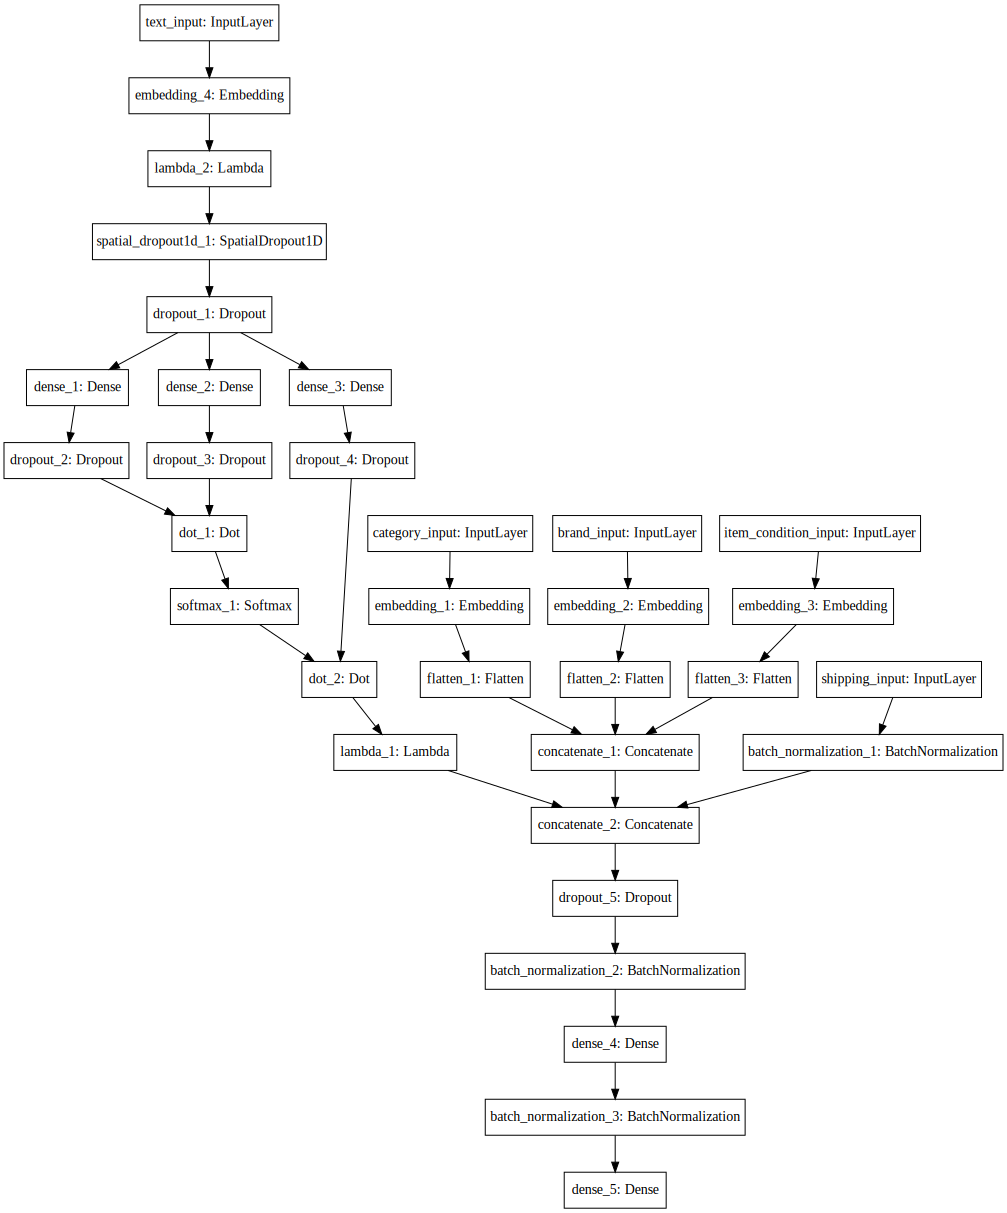

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [30]:
def rmsle(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred+1.) - K.log(y_true+1.))))
model.compile(loss=rmsle, optimizer='adam')

In [31]:
model.fit_generator(
    Xy_train_gen(),
    epochs=10,
    steps_per_epoch=train_batches,
    validation_data=Xy_test_gen(),
    validation_steps=test_batches,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2),
               keras.callbacks.EarlyStopping(patience=3),
               keras.callbacks.TerminateOnNaN()]
)

Epoch 1/10
2048/2048 [==============================] - 123s 60ms/step - loss: 0.9544 - val_loss: 0.8149
Epoch 2/10
2048/2048 [==============================] - 130s 64ms/step - loss: 0.5894 - val_loss: 0.8396
Epoch 3/10
2048/2048 [==============================] - 133s 65ms/step - loss: 0.5712 - val_loss: 0.7677
Epoch 4/10
2048/2048 [==============================] - 149s 73ms/step - loss: 0.5392 - val_loss: 0.7378
Epoch 5/10
2048/2048 [==============================] - 99s 48ms/step - loss: 0.5288 - val_loss: 0.7197
Epoch 6/10
2048/2048 [==============================] - 83s 41ms/step - loss: 0.5219 - val_loss: 0.7084
Epoch 7/10
2048/2048 [==============================] - 101s 49ms/step - loss: 0.5209 - val_loss: 0.7073
Epoch 8/10
2048/2048 [==============================] - 129s 63ms/step - loss: 0.5217 - val_loss: 0.6990
Epoch 9/10
2048/2048 [==============================] - 137s 67ms/step - loss: 0.5201 - val_loss: 0.6926
Epoch 10/10
2048/2048 [==============================] - 